# LNCMI planning

## General information

- **Context of the study**: This notebook presents a use case on the LNCMI's waste heat recovery project. The objective is to reschedule of the LNCMI planning of experiments in order to imporove the technical waste heat recovery potential of the facility, on the local district heating network.
- **Licence**: [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html)
- mybinder link for online use [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fomegalpes%2Fomegalpes_examples/HEAD?labpath=%2Fnotebooks%2FPhD_2022_Sacha_Hodencq%2FLNCMI_planning.ipynb)
- **Reference**: coming article in the Journal of Cleaner Production
- **Tool** : [OMEGAlpes](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes), version 0.4.1, Apache 2.0 licence 
- Link to other related case studies:
   - See in particular the ECOS conference paper "[Flexible waste heat management and recovery for an electro-intensive industrial process through energy/exergy criteria](https://hal.archives-ouvertes.fr/hal-03290126)" presenting the same case study.   
   - section IV.2.6.1 of [Sacha Hodencq's thesis](http://www.theses.fr/s225905).
   - and the [LNCMI notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/LNCMI.ipynb) for mediation purposes.
   - Also this article uses the [ORUCE](https://hal.archives-ouvertes.fr/hal-03341883) (Open and Reproducible Use Case for Energy) method.
- **Developer - institution** : Sacha Hodencq (sacha.hodencq@g2elab.grenoble-inp.fr) - G2Elab, Jaume Fito, LOCIE 
- [Use case summary sheet](#Use-case-specifications) at the end of the notebook

## Table of content

- [General information](#General-information)
- [Data management](#Data-management)
- [Energy modelling introduction](#Energy-modelling-introduction)
- Energy modelling process
   - [LNCMI simplified model](LNCMI-simplified-model)
   - [LNCMI model](LNCMI-model)
- [Output management](#Output-management)
- [Conclusion](#Conclusion)
- [Use case specifications](#Use-case-specifications)

**Importing relevant packages**

Also see [OMEGAlpes documentation](https://omegalpes-examples.readthedocs.io/en/latest/jupyter.html) for using the relevant environement depending on your situation.

***Code to execute if you are using mybinder*** (remove the "#" in front of the code lines) :

In [1]:
#############################################################################
# import os
# os.system('pip install -r NB_requirements/LNCMI_planning_requirements.txt')
#############################################################################

In [2]:
import pulp
import os
import math

from pulp import LpStatus, GUROBI_CMD

import numpy as np
from python_scripts.NB_LNCMI_planning_utils import *
import matplotlib.lines as lines
from pandas import Series
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Data management

### LNCMI consumption profile


LNCMI consumption profile (metadata based on the [OEMetadata](https://github.com/OpenEnergyPlatform/oemetadata/blob/develop/metadata/latest/metadata_key_description.md)) : 

|#|Key |Parameter |
|---|---|---|
| 1 | name |irradiance_data.csv| 
| 2 | title | Irradiance data in Grenoble in 2019| 
| 3 | id | |
| 4 | description | Irradiance data in Grenoble including DHI and DNI |
| 5 | language | |
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate |2020 |
| 9 | context | |
| 10 | spatial |Grenoble, 21 avenue des Martyrs| 
| 11 | temporal | 2019, hourly time step|
| 12 | source |http://mhi-srv.g2elab.grenoble-inp.fr/API/ |
| 13 | licenses | Public Domain Dedication and License version v1.0. |
| 14 | contributors | Delinchant B. and Laranjeira T. |
| 15 | resources |Delinchant B., Wurtz F., Ploix S., Schanen J.-L. and Marechal Y. (2016). "GreEn-ER Living Lab - A Green Building with Energy Aware Occupants". SmartGreen'16, In proceedings of the 5th International Conference on Smart Cities and Green ICT Systems. ISBN 978-989-758-184-7, pages 316-323. DOI: 10.5220/0005795303160323 |

The first step is to define the parameters that will allow the first calculations to be made on the data:
- The start and end dates of the study
- The ratio between the electrical power consumed by the LNCMI magnets (i.e. the dissipated heat) and the total electricity consumed on the LNCMI site *elec_to_heat_ratio*.
- The threshold power above which a constant temperature can be guaranteed for waste heat recovery *p_thresh_reco*
- The power of the recovery system *p_max_recov*, which will depend on its sizing. This is the sum of the thermal power at the heat pump input *p_hp*, and the storage power *p_sto*.

The calculations will be made in kW.

In [3]:
# two semesters
start_date1='01/01/2018 00:00'
end_date1='30/06/2018 23:50'

start_date2='01/07/2018 00:00'
end_date2='31/12/2018 23:50'

elec_to_heat_ratio=0.85
p_thresh_reco=8.5 * 1e3
capa_sto = 20  # MWh
p_sto = capa_sto/3  # MW
p_hp = 2.5  # MW
p_max_reco=(p_sto+p_hp) * 1e3

In [4]:
lncmi_cons_raw1 = select_csv_file_between_dates(
        "data/cons_lncmi_v7.csv", start_date1, end_date1)
lncmi_cons_raw2 = select_csv_file_between_dates(
        "data/cons_lncmi_v7.csv", start_date2, end_date2)
print(lncmi_cons_raw1)
print(lncmi_cons_raw2)

date
2018-01-01 00:00:00      38
2018-01-01 01:00:00      40
2018-01-01 02:00:00      40
2018-01-01 03:00:00      38
2018-01-01 04:00:00      39
                       ... 
2018-06-30 19:00:00    2011
2018-06-30 20:00:00       0
2018-06-30 21:00:00       0
2018-06-30 22:00:00       0
2018-06-30 23:00:00       0
Name: value, Length: 4344, dtype: int64
date
2018-07-01 00:00:00    0
2018-07-01 01:00:00    0
2018-07-01 02:00:00    0
2018-07-01 03:00:00    0
2018-07-01 04:00:00    0
                      ..
2018-12-31 19:00:00    0
2018-12-31 20:00:00    0
2018-12-31 21:00:00    0
2018-12-31 22:00:00    0
2018-12-31 23:00:00    0
Name: value, Length: 4416, dtype: int64


The ratio between the electrical power consumed by the LNCMI magnets is applied to obtain the power consumption profile of the magnets alone, i.e. the heat dissipation profile.

In [5]:
# LNCMI facility electricity consumption
lncmi_elec = Series.append(lncmi_cons_raw1.copy(),lncmi_cons_raw2.copy())
# LNCMI magnets electrical consumption, equals their heat dissipation
lncmi_heat = lncmi_elec*elec_to_heat_ratio
lncmi_heat_monotonic = lncmi_heat.copy().sort_values(ascending=False)

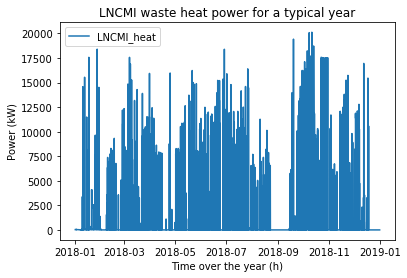

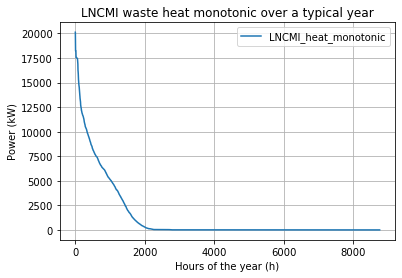

In [6]:
fig1, ax1 = plt.subplots()  
ax1.plot(lncmi_heat, label='LNCMI_heat') 
ax1.set_xlabel('Time over the year (h)')  
ax1.set_ylabel('Power (kW)')  
ax1.set_title('LNCMI waste heat power for a typical year')
ax1.legend() 
# Hours of a year
h_list = [h for h in range(0,8760)]

fig2, ax2 = plt.subplots()  
ax2.plot(h_list, lncmi_heat_monotonic, label='LNCMI_heat_monotonic')
ax2.set_xlabel('Hours of the year (h)')  
ax2.set_ylabel('Power (kW)')  
ax2.set_title('LNCMI waste heat monotonic over a typical year')
plt.grid()

ax2.legend() 

Now let's determine : 
- The **Theoretical waste heat** (*theoretical_wh*): the power consumption of the magnets, which is completely dissipated as heat. 
- The **available waste heat** (*available_wh*): waste heat for power values above the threshold power value to ensure a constant temperature.
- The **Recoverable waste heat** (*recov_wh*): available waste heat capped by the maximum power of the heat recovery system. It can be noted that the charging and discharging time of the storage is 3 hours, so the storage will be fully charged after 3 hours at maximum power and will not be able to store any more energy.
- The **Technical waste heat potential**: the share of recoverable waste heat that can be used for heat consumption, that we will determine at the end of this study.

In [7]:
theoretical_wh = lncmi_heat.sum()
print("Theoretical waste heat here represents {} MWh".format(round(theoretical_wh/1e3)))
available_wh = lncmi_heat[lncmi_heat >=p_thresh_reco].sum()
print("Available waste heat here represents {} MWh".format(round(available_wh/1e3)))

Theoretical waste heat here represents 11708 MWh
Available waste heat here represents 5858 MWh


In [8]:
for capa in [0, 10, 20, 30, 40] :
    lncmi_heat_reco = lncmi_heat.copy()
    pmax_reco=(capa/3+p_hp) * 1e3
    lncmi_heat_reco.loc[lncmi_heat_reco < p_thresh_reco] = 0
    lncmi_heat_reco.loc[lncmi_heat_reco >= pmax_reco] = pmax_reco
    recov_wh = lncmi_heat_reco.sum()
    print("Available waste heat here represents {0} MWh for a {1} MWh storage capacity".format(round(recov_wh/1e3),capa))

Available waste heat here represents 1202 MWh for a 0 MWh storage capacity
Available waste heat here represents 2806 MWh for a 10 MWh storage capacity
Available waste heat here represents 4385 MWh for a 20 MWh storage capacity
Available waste heat here represents 5311 MWh for a 30 MWh storage capacity
Available waste heat here represents 5712 MWh for a 40 MWh storage capacity


### Consumption profiles
The consumption profile of the local district heating network on which it is envisaged to inject the waste heat is a data set made available by the CCIAG (Grenoble district heating network operator) in the scope of this project, but these data are not freely accessible. The associated metadata are presented below.

Consumption (based on the [OEMetadata](https://github.com/OpenEnergyPlatform/oemetadata/blob/develop/metadata/latest/metadata_key_description.md)) : 

|#|Key |Parameter |
|---|---|---|
| 1 | name | District_heat_load_predicted.csv|
| 2 | title | Presqu'île conversion profile| 
| 3 | id | |
| 4 | description | Annual consumption profile of district heating customers for substations planned to be converted to low pressure in the Presqu'île district of Grenoble |
| 5 | language | fr|
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate | 2018|
| 9 | context | |
| 10 | spatial |France, district scale| 
| 11 | temporal | 2018, hourly time step|
| 12 | source |CCIAG |
| 13 | licenses |  all rights reserved |
| 14 | contributors | [CCIAG](https://www.compagniedechauffage.fr/) |
| 15 | resources | |

In [9]:
# two semesters
district_consumption1 = select_csv_file_between_dates(
    'data/district_heat_load_predicted.csv', start_date1, end_date1)
district_consumption2 = select_csv_file_between_dates(
    'data/district_heat_load_predicted.csv', start_date2, end_date2)
# NB : these data are confidential and currently not shared in open data
district_consumption = Series.append(district_consumption1.copy(),district_consumption2.copy())

The operating temperature of the heat network is approximated with the following water logic: 
![loi_eau](figures/water_logic.png)

The outdoor temperature data were obtained from private sources for 2018. But they can be downloaded via the [GreEn-Er weather station](https://g2elab-shiny.g2elab.grenoble-inp.fr/meteo-greener/#dashboard) (G2Elab and ENSE3 school building), stored on the MHI (Monitoring and Intelligent Housing) server in an [influxDB database](http://mhi-srv.g2elab.grenoble-inp.fr/API/) under a [Public Domain Dedication and License version v1.0](https://opendatacommons.org/licenses/pddl/1-0/) licence.

In [10]:
# # Using get_data function
# data_url=get_data(url="http://mhi-srv.g2elab.grenoble-inp.fr/API/environment")
# # In the obtained data, plot 3 includes irradiance data we are looking for
# data_sun_url = data_url['plot3']
# # Converting into dataframe
# df_sun_url = pd.DataFrame.from_records(data_sun_url['values'])
# # Adding headers. Plot3 includes date in epoch format, Diffuse Horizontal Irradiance and Global Horizontal Irradiance
# df_sun_url.columns = ["date","DHI (W/m²)", "DNI (W/m²)", "GHI (W/m²)"]
# # Converting epoch time format to datatime
# df_sun_url['date'] = pd.to_datetime(df_sun_url['date'],unit='s')
# print(df_sun_url)

In [11]:
# A TESTER
# heating_network_temp = []*len(heat_lncmi)
# for h in len(h_list):
#     if ext_temp[h]<=-11:
#         heating_network_temp[h]=119
#     elif ext_temp[h]<=0
#         heating_network_temp[h]=110
#     elif ext_temp[h]<=5
#         heating_network_temp[h]=100
#     elif ext_temp[h]<=20
#         heating_network_temp[h]=90
#     else :
#         heating_network_temp[h]=85

In [12]:
heating_network_temp1 = select_csv_file_between_dates(
    "data/loi_eau_approx.csv", start_date1, end_date1)
heating_network_temp2 = select_csv_file_between_dates(
    "data/loi_eau_approx.csv", start_date2, end_date2)
heating_network_temp=Series.append(heating_network_temp1.copy(),heating_network_temp2.copy())

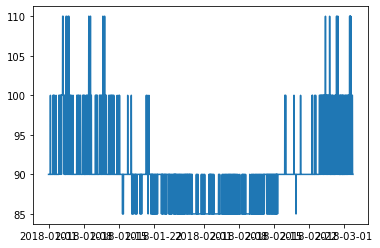

In [13]:
fig4, ax4 = plt.subplots()  
ax4.plot(Series.append(heating_network_temp1,heating_network_temp2))

## Energy modelling introduction

### General description

Firstly, a simplified model of the waste heat recovery project is used to rearrange the 7-day energy blocks according to the consumption profile of the heating network. Storage is not explicitly considered since the time step is 168 hours. The threshold power value for waste heat recovery as well as the maximum power capacities of the storage and the heat pump are taken into account in the input data management in order to determine the recoverable fatal heat. The fixed district heating consumption is also an input. The optimisation here has two objectives:
- To maximise the recovered waste heat, i.e. to minimise the heat output of the district heating network.
- To minimise the difference between the energy consumed in the heating network and the energy output of the heat pump at each time step, weighted by the consumption value in the network. This objective allows to order the consumption and production blocks at relatively close levels over the whole study period. This objective is described below, with EDHN the energy consumed on the district heating network, and E_HP the heat pump output energy. 
$$fitting objective=\sum_{t=1}^{52} (E_{DHN} [t]-E_{HP} [t])*E_{DHN} [t]$$

A second, more detailed OMEGAlpes model is then used to determine the optimal storage management and calculate the annual performance with the rearranged power profiles. This model includes the following elements:
- An electricity supplier feeding both the LNCMI and the heat pump. 
- A power to heat conversion unit representing the LNCMI experiments.
- The LNCMI's heat dissipation unit in Isère. 
- A thermocline energy storage unit, with a minimum total charge or discharge time of 3 hours. The storage must reach its maximum state of charge at least once every 5 days in order to evacuate the gradient zone when it becomes too large. 
- A heat pump (HP) unit. 
- A heat network. 
- A heat production unit, representing the CCIAG's own heat production facilities.
- A district heating consumption unit.
- Several energy nodes between the units, ensuring power balances. A constraint stops the export between the magnet output node and the recovery node when the LNCMI power is below the threshold value of 8.5 MWth.

The objective is to maximise the recovered waste heat, i.e. to minimise the heat production of the district heating network.
![LNCMI strat](./figures/LNCMI_strategy.png)

## Energy modelling process

### Simplified model
First, a simplified LNCMI model is used for the replanification.
#### Use case diagram

![LNCMI_simple](./figures/LNCMI_simplified.png)

#### Time management

With open source solvers such as CBC (the default solver used with PuLP in OMEGAlpes), it is best to study periods shorter than a season in terms of duration (i.e. 3 months). A season will be solved in about 5 minutes. The performance will be improved with solvers such as Gurobi or Cplex.
Given these limitations, the following section allows for the choice of dates at which the study is carried out according to user preferences.

In [14]:
dt = 24*7  # Time step of one week

#### Semester 1

In [15]:
# Creating an empty model

time = TimeUnit(start=start_date1, end=end_date1, dt=dt)
model = OptimisationModel(name='lncmi_semester1_model', time=time)

You are studying the period from 2018-01-01 00:00:00 to 2018-06-25 00:00:00


##### Instanciation of the energy model

We assemble the energy model thanks to nodes, and add the objective function

In [16]:
# Getting energy profiles for the LNCMI recoverable heat production and
# the district heating 1 hour power profiles, for both semesters
print("Building the model for semester 1")
dict_lncli={}
e_values_dh = []
e_values_lncmi1 = []
#  lncmi_cons_raw, district_consumption, time, model
e_values_lncmi1, e_values_dh, dict_lncmi = \
    power_to_energy_profile_lncmi(lncmi_profile_raw=lncmi_cons_raw1,
                                  dh_profile_raw=district_consumption1,
                                  time_step=dt,
                                  elec_to_heat_ratio=elec_to_heat_ratio,
                                  p_thresh_reco=p_thresh_reco,
                                  p_max_recov=p_max_reco)
# Equivalent maximum power that is here a maximum energy flow at the 7
# days time step.
pmax_eq = (max(max(e_values_dh), max(e_values_lncmi1)) + 1e3)/time.DT
print("pmax_eq = {}".format(pmax_eq))

# --- LNCMI CREATION ---
# Here each energy block of the LNCMI is modelled as a single Variable
# Production Unit
lncmi_energy_blocks = rearrange_profile(time, e_values_lncmi1)

# Constraint expression for runs not to occur at the same time
u_exp = ''
for e_block in lncmi_energy_blocks:
    u_exp += '{0}_u[t] + '.format(e_block.name)
u_exp += '0 <= 1'

dissipation = VariableConsumptionUnit(time, 'dissipation', p_max=pmax_eq,
                                      energy_type='Thermal')

# --- DISTRICT HEAT LOAD CREATION ---
p_dh = [e/time.DT for e in e_values_dh]
district_heat_load = FixedConsumptionUnit(time, 'district_heat_load',
                                          p=p_dh,
                                          energy_type='Thermal')

# --- HEAT PUMP CREATION ---
# The heat pump is simplified due to the energy block consideration,
# pmax_eq_hp is also a maximum energy flow at the 7 days time step,
# with 3.5MW the maximal outlet power value of the heat pump

pmax_hp = 3.5e3
print("pmax_eq_hp = {}".format(pmax_hp))

heat_pump = HeatPump(time, "heat_pump", cop=3,
                     pmax_out_therm=pmax_hp, pmax_in_elec=pmax_hp,
                         pmax_in_therm=pmax_hp)

# Creating the source of electricity for heat pump
elec_prod = VariableProductionUnit(time, 'elec_prod',
                                   energy_type='Electrical', p_max=pmax_eq)

# --- DISTRICT HEATING PRODUCTION CREATION ---
#  heat production plants
heat_production = VariableProductionUnit(time, name='heat_production',
                                         energy_type='Thermal',
                                         p_max=pmax_eq)

# --- HEAT NODES CREATION ---
# Creating the heat node for the energy flows
# Heat node for the LNCMI current system
heat_node_lncmi = EnergyNode(time, 'heat_node_lncmi',
                             energy_type='Thermal')
# Heat node for the district heating network
heat_node_network = EnergyNode(time, 'heat_node_network',
                               energy_type='Thermal')
# Electricity node for the electrical consumption from the LNCMI and the
#  heat pump
elec_node = EnergyNode(time, 'elec_node', energy_type='Electrical')

heat_node_lncmi.non_sup_exp = TechnicalDynamicConstraint(u_exp,
                                                         name=
                                                         'non_sup_exp',
                                                         parent=
                                                         heat_node_lncmi)

# Connecting all units on the same energy node
heat_node_lncmi.connect_units(dissipation,
                              heat_pump.thermal_consumption_unit,
                              *lncmi_energy_blocks)
# lncmi_single_block, lncmi_second_block)

# Connecting units to the nodes
elec_node.connect_units(elec_prod, heat_pump.elec_consumption_unit)
heat_node_network.connect_units(heat_pump.thermal_production_unit,
                                heat_production, district_heat_load)

# --- OBJECTIVE CREATION ---
# Objective 1 : Minimizing the part of the heat load covered by the heat
# production plants
heat_production.minimize_production()

# Objective 2 : Minimising the difference between the district heat load
# energy and the waste heat production from the heat pump at a given time
# step, weighted with the district heat load energy value; for the energy
# planning of the LNCMI to fit the district heating energy profiles.
# This objective ensures to sort energy consumption and production
# relatively at the same levels for the whole studied period.
exp_obj = 'lpSum((district_heat_load_p[t]-heat_pump_therm_prod_p[t])' \
          '*district_heat_load_p[t] for t in time.I)'

fitting_obj = Objective(name='fitting', exp=exp_obj,
                        parent=heat_production)

setattr(heat_production, 'fitting', fitting_obj)

# --- ADDING ALL UNITS TO THE OPTIMIZATION MODEL ---
model.add_nodes(heat_node_lncmi, heat_node_network, elec_node)

# Writing into lp file
# model.writeLP('optim_models\lncmi_simple_case.lp')

Building the model for semester 1
pmax_eq = 7780.051785714281
Creating the block_nb_1.
Creating the block_nb_2.
Creating the block_nb_3.
Creating the block_nb_4.
Creating the block_nb_5.
Creating the block_nb_6.
Creating the block_nb_7.
Creating the block_nb_8.
Creating the block_nb_9.
Creating the block_nb_10.
Creating the block_nb_11.
Creating the block_nb_12.
Creating the block_nb_13.
Creating the block_nb_14.
Creating the block_nb_15.
Creating the block_nb_16.
Creating the block_nb_17.
Creating the block_nb_18.
Creating the block_nb_19.
Creating the block_nb_20.
Creating the block_nb_21.
Creating the block_nb_22.
Creating the block_nb_23.
Creating the block_nb_24.
Creating the block_nb_25.
Creating the block_nb_26.
Creating the dissipation.
Creating the district_heat_load.
pmax_eq_hp = 3500.0
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the elec_prod.
Creating the heat_production.
Creating t

Adding constraint : block_nb_19_on_off_max , exp = block_nb_19_p[t] <= block_nb_19_u[t] * 972.9839404761905 for t in time.I
Adding constraint : block_nb_19_on_off_min , exp = block_nb_19_p[t] >= block_nb_19_u[t] * 972.9839404761905 for t in time.I
Adding constraint : block_nb_19_set_e_min , exp = block_nb_19_e_tot >= 163461.302
Adding constraint : block_nb_19_set_e_max , exp = block_nb_19_e_tot <= 163461.302
Adding constraint : block_nb_20_calc_e_tot , exp = block_nb_20_e_tot == time.DT * lpSum(block_nb_20_p[t] for t in time.I)
Adding constraint : block_nb_20_on_off_max , exp = block_nb_20_p[t] <= block_nb_20_u[t] * 272.7350416666667 for t in time.I
Adding constraint : block_nb_20_on_off_min , exp = block_nb_20_p[t] >= block_nb_20_u[t] * 272.7350416666667 for t in time.I
Adding constraint : block_nb_20_set_e_min , exp = block_nb_20_e_tot >= 45819.487
Adding constraint : block_nb_20_set_e_max , exp = block_nb_20_e_tot <= 45819.487
Adding constraint : block_nb_21_calc_e_tot , exp = block

##### Solving

In [17]:
model.solve_and_update(GUROBI_CMD())  # Run optimization and update
# values, either with CBC as a default solver, or with GUROBI

# Extracting the rearranged LNCMI energy profile
e_lncmi_rearranged1 = []
for p_d, p_hp in zip(dissipation.p.get_value(),
                     heat_pump.thermal_consumption_unit.p.get_value()):
    e_lncmi_rearranged1.append(round(p_d*time.DT + p_hp*time.DT, 3))

# Rebuilding the rearranged LNCMI power profile
p_lncmi_rearranged_sem1 = rebuild_profile(e_lncmi_rearranged1, dict_lncmi)


 - - - - - RUN OPTIMIZATION - - - - - 

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : heat_node_lncmi
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_1
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_2
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_3
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_4
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_5
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_6
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_7
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_8
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_9
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_10
	Quantity : p
	Quantity : e_tot
	Quantity : u
Up

***Semester 2***

In [18]:
# Creating an empty model
time = TimeUnit(start=start_date2, end=end_date2, dt=dt)
model = OptimisationModel(name='lncmi_semester2_model', time=time)

# Getting energy profiles for the LNCMI recoverable heat production and
# the district heating 1 hour power profiles, for both semesters
print("Building the model for semester 2")
dict_lncli={}
e_values_dh = []
e_values_lncmi2 = []
#  lncmi_cons_raw, district_consumption, time, model
e_values_lncmi2, e_values_dh, dict_lncmi = \
    power_to_energy_profile_lncmi(lncmi_profile_raw=lncmi_cons_raw2,
                                  dh_profile_raw=district_consumption2,
                                  time_step=dt,
                                  elec_to_heat_ratio=elec_to_heat_ratio,
                                  p_thresh_reco=p_thresh_reco,
                                  p_max_recov=p_max_reco)
# Equivalent maximum power that is here a maximum energy flow at the 7
# days time step.
pmax_eq = (max(max(e_values_dh), max(e_values_lncmi2)) + 1e3)/time.DT
print("pmax_eq = {}".format(pmax_eq))

# --- LNCMI CREATION ---
lncmi_energy_blocks = rearrange_profile(time, e_values_lncmi2)

# Constraint expression for runs not to occur at the same time
u_exp = ''
for e_block in lncmi_energy_blocks:
    u_exp += '{0}_u[t] + '.format(e_block.name)
u_exp += '0 <= 1'

dissipation = VariableConsumptionUnit(time, 'dissipation', p_max=pmax_eq,
                                      energy_type='Thermal')

# --- DISTRICT HEAT LOAD CREATION ---
p_dh = [e/time.DT for e in e_values_dh]
district_heat_load = FixedConsumptionUnit(time, 'district_heat_load',
                                          p=p_dh,
                                          energy_type='Thermal')

# --- HEAT PUMP CREATION ---
pmax_hp = 3.5e3
print("pmax_eq_hp = {}".format(pmax_hp))

heat_pump = HeatPump(time, "heat_pump", cop=3,
                     pmax_out_therm=pmax_hp, pmax_in_elec=pmax_hp,
                         pmax_in_therm=pmax_hp)

# Creating the source of electricity for heat pump
elec_prod = VariableProductionUnit(time, 'elec_prod',
                                   energy_type='Electrical', p_max=pmax_eq)

# --- DISTRICT HEATING PRODUCTION CREATION ---
#  heat production plants
heat_production = VariableProductionUnit(time, name='heat_production',
                                         energy_type='Thermal',
                                         p_max=pmax_eq)

# --- HEAT NODES CREATION ---
# Heat node for the LNCMI current system
heat_node_lncmi = EnergyNode(time, 'heat_node_lncmi',
                             energy_type='Thermal')
# Heat node for the district heating network
heat_node_network = EnergyNode(time, 'heat_node_network',
                               energy_type='Thermal')
# Electricity node for the electrical consumption from the LNCMI and the
#  heat pump
elec_node = EnergyNode(time, 'elec_node', energy_type='Electrical')

heat_node_lncmi.non_sup_exp = TechnicalDynamicConstraint(u_exp,
                                                         name=
                                                         'non_sup_exp',
                                                         parent=
                                                         heat_node_lncmi)

# Connecting all units on the same energy node
heat_node_lncmi.connect_units(dissipation,
                              heat_pump.thermal_consumption_unit,
                              *lncmi_energy_blocks)
# lncmi_single_block, lncmi_second_block)

# Connecting units to the nodes
elec_node.connect_units(elec_prod, heat_pump.elec_consumption_unit)
heat_node_network.connect_units(heat_pump.thermal_production_unit,
                                heat_production, district_heat_load)

# --- OBJECTIVE CREATION ---
# Objective 1
heat_production.minimize_production()

# Objective 2
exp_obj = 'lpSum((district_heat_load_p[t]-heat_pump_therm_prod_p[t])' \
          '*district_heat_load_p[t] for t in time.I)'

fitting_obj = Objective(name='fitting', exp=exp_obj,
                        parent=heat_production)

setattr(heat_production, 'fitting', fitting_obj)

# --- ADDING ALL UNITS TO THE OPTIMIZATION MODEL ---
model.add_nodes(heat_node_lncmi, heat_node_network, elec_node)

model.solve_and_update(GUROBI_CMD())  # Run optimization and update
# values, either with CBC as a default solver, or with GUROBI

# Extracting the rearranged LNCMI energy profile
e_lncmi_rearranged2 = []
for p_d, p_hp in zip(dissipation.p.get_value(),
                     heat_pump.thermal_consumption_unit.p.get_value()):
    e_lncmi_rearranged2.append(round(p_d*time.DT + p_hp*time.DT, 3))

# Rebuilding the rearranged LNCMI power profile
p_lncmi_rearranged_sem2 = rebuild_profile(e_lncmi_rearranged2, dict_lncmi)

You are studying the period from 2018-07-01 00:00:00 to 2018-12-30 00:00:00
Building the model for semester 2
pmax_eq = 5705.660119047621
Creating the block_nb_1.
Creating the block_nb_2.
Creating the block_nb_3.
Creating the block_nb_4.
Creating the block_nb_5.
Creating the block_nb_6.
Creating the block_nb_7.
Creating the block_nb_8.
Creating the block_nb_9.
Creating the block_nb_10.
Creating the block_nb_11.
Creating the block_nb_12.
Creating the block_nb_13.
Creating the block_nb_14.
Creating the block_nb_15.
Creating the block_nb_16.
Creating the block_nb_17.
Creating the block_nb_18.
Creating the block_nb_19.
Creating the block_nb_20.
Creating the block_nb_21.
Creating the block_nb_22.
Creating the block_nb_23.
Creating the block_nb_24.
Creating the block_nb_25.
Creating the block_nb_26.
Creating the block_nb_27.
Creating the dissipation.
Creating the district_heat_load.
pmax_eq_hp = 3500.0
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pu

Adding constraint : block_nb_7_set_e_min , exp = block_nb_7_e_tot >= 18006.674
Adding constraint : block_nb_7_set_e_max , exp = block_nb_7_e_tot <= 18006.674
Adding constraint : block_nb_8_calc_e_tot , exp = block_nb_8_e_tot == time.DT * lpSum(block_nb_8_p[t] for t in time.I)
Adding constraint : block_nb_8_on_off_max , exp = block_nb_8_p[t] <= block_nb_8_u[t] * 4.761904761904762e-05 for t in time.I
Adding constraint : block_nb_8_on_off_min , exp = block_nb_8_p[t] >= block_nb_8_u[t] * 4.761904761904762e-05 for t in time.I
Adding constraint : block_nb_8_set_e_min , exp = block_nb_8_e_tot >= 0.008
Adding constraint : block_nb_8_set_e_max , exp = block_nb_8_e_tot <= 0.008
Adding constraint : block_nb_9_calc_e_tot , exp = block_nb_9_e_tot == time.DT * lpSum(block_nb_9_p[t] for t in time.I)
Adding constraint : block_nb_9_on_off_max , exp = block_nb_9_p[t] <= block_nb_9_u[t] * 5.357142857142857e-05 for t in time.I
Adding constraint : block_nb_9_on_off_min , exp = block_nb_9_p[t] >= block_nb_9


 - - - - - UPDATE RESULTS - - - - - 
Updating unit : heat_node_lncmi
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_1
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_2
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_3
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_4
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_5
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_6
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_7
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_8
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_9
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_10
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : block_nb_11
	Quantity : p


Assembling results of both semesters

In [19]:
p_lncmi_rearranged=p_lncmi_rearranged_sem1+p_lncmi_rearranged_sem2
e_values_lncmi=e_values_lncmi1+e_values_lncmi2
e_lncmi_rearranged=e_lncmi_rearranged1+e_lncmi_rearranged2
time = TimeUnit(start=start_date1, end=end_date2, dt=dt)

You are studying the period from 2018-01-01 00:00:00 to 2018-12-31 00:00:00


##### Printing results

In [20]:
# print("\n - - - - - OPTIMIZATION RESULTS - - - - - ")
# print('District consumption = {0} GWh.'.format(
#     round(district_heat_load.e_tot.value / 1e6, 2)))
# # print('LNMCI electrical consumption (GWh)= ',
# #       round(lncmi.elec_consumption_unit.e_tot.value / 1e6, 2))
# print('District Heating production (GWh)= ', round(
#     heat_production.e_tot.value/ 1e6, 2))
# print('LNMCI heat transferable on the district heating network by the '
#       'Heat Pump (GWh)= ', round(
#     heat_pump.thermal_production_unit.e_tot.value / 1e6, 2))
# print('Heat_pump heat consumption (GWh)= ',
#       round(heat_pump.thermal_consumption_unit.e_tot.value / 1e6, 2))
# print('Heat pump electricity consumption (GWh)= ', 
#       round(heat_pump.elec_consumption_unit.e_tot.value / 1e6, 2))


##### Plot results

Text(0, 0.5, 'Power (kW)')

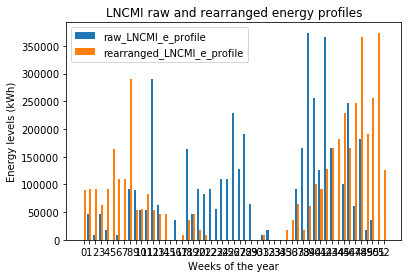

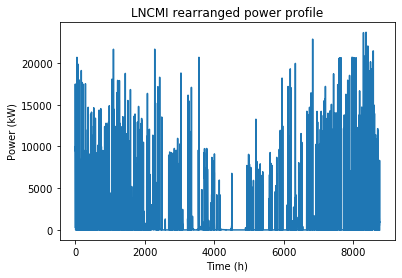

In [21]:
# PLOTS
fig, ax = plt.subplots()
width = 0.35
raw_lncmi = ax.bar(time.I - width / 2, e_values_lncmi, width,
                   label='raw_LNCMI_e_profile')
rearr_lncmi = ax.bar(time.I + width / 2, e_lncmi_rearranged,
                     width, label='rearranged_LNCMI_e_profile')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy levels (kWh)')
ax.set_xlabel('Weeks of the year')
ax.set_title('LNCMI raw and rearranged energy profiles')
ax.set_xticks(time.I)
ax.legend()
# LNCMI power profile
plt.figure()
plt.plot(p_lncmi_rearranged)
plt.title(label='LNCMI rearranged power profile')
plt.xlabel(xlabel='Time (h)')
plt.ylabel(ylabel='Power (kW)')
# # Power flows
# plot_node_energetic_flows(heat_node_lncmi)
# plot_node_energetic_flows(heat_node_network)
# plt.show()

##### Saving results
Finally, energy flows can be saved as csv files to keep a trace of these intermediate results

In [22]:
df = pd.DataFrame(p_lncmi_rearranged)
df.to_csv('results\p_rearranged_lncmi_simplified_TS_{}_hours'.format(dt),
          header=True, index=False, sep=';')

##### Results discussion

### LNCMI model
A more detailed model of the LNCMI is now used to get the energy results from this replanification, i.e. an evaluation of the waste heat technical potential.
#### Use case diagram
![LNCMI](./figures/LNCMI.png)

#### Model instanciation rearranged

In [23]:
dt = 1  # Delta t (=1 for one hour ; 1/6 for 10min)
start_date = "01/01/2018 00:00"  # starting date of the study, format DD/MM/YYYY HH:MM
end_date = "31/12/2018 23:50"  # ending date of the study
winter_only = False  # The waste can only be recovered in winter i.e. from
# November to March
lncmi_cons_config = 'fixed'  # Choose between 'free','fixed'. HERE, fixed is chosen because it has been rearranged beforehand.
# In order to get the reference scenario, the input data must directly come from the LNCMI current consumption in the data files (see new_lncmi_cons).
water_logic = False
e_set_lncmi = 13.77*1e6  # Electrical power consumed by the LNCMI during a year [kWh]
cciag_pmax = 2e4
e0_sto = None
hp_elec_costs = 0.0817  # 81,7 €/MWh
hp_config = 2
p_min_export = 8500
lncmi_power = 24
lncmi_power_ratio = lncmi_power / 24  # in order to translate the consumption from 24 MW to 30 or 36 MW for instance
storage_capa = [0, 10, 20, 30, 40]
new_lncmi_cons = [lncmi_power_ratio * float(p) for p in p_lncmi_rearranged]
heat_cons = [float(p) for p in district_consumption]

strategy_name = 'rearranged'  # because new_lncmi_cons comes from the rearranged one.

In [24]:
lncmi={}
heat_pump={} 
heat_production={}
district_heat_load={} 
heat_node_lncmi={} 
heat_node_recovery={} 
heat_node_network={}

In [25]:
for sto_capa in storage_capa:
    print("Study for a storage capacity of {} MWh".format(sto_capa))
    lncmi[sto_capa], heat_pump[sto_capa], heat_production[sto_capa], district_heat_load[sto_capa], heat_node_lncmi[sto_capa], heat_node_recovery[sto_capa], heat_node_network[sto_capa] = lncmi_model(dt, start_date, end_date, lncmi_cons_config, lncmi_cons=new_lncmi_cons, 
                heat_cons=heat_cons, water_logic_values=heating_network_temp, 
                elec_to_heat_ratio=elec_to_heat_ratio, storage_capa=sto_capa, cciag_pmax=cciag_pmax,
                e_lncmi=e_set_lncmi, p_thresh_reco=p_min_export, lncmi_power=lncmi_power, 
                winter_only=winter_only, water_logic=water_logic)
#     print_results(dt)
#     plot_node_energetic_flows(heat_node_lncmi)
#     plot_node_energetic_flows(heat_node_recovery)
#     plot_node_energetic_flows(heat_node_network)
#     plt.show()

Study for a storage capacity of 0 MWh
You are studying the period from 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Creating the lncmi_therm_prod.
Creating the lncmi_elec_cons.
Creating the lncmi.
Creating the dissipation.
Creating the district_heat_load.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the elec_prod.
Creating the heat_production.
Creating the heat_node_lncmi.
Creating the heat_node_recovery.
Creating the heat_node_network.
Creating the elec_node.


C:\Users\hodencqs\Anaconda3\envs\worklab\lib\site-packages\omegalpes\general\optimisation\model.py:573: UserWarning: The unit heat_node_lncmi seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  warnings.warn('The unit {} seems to have as parent {} '
C:\Users\hodencqs\Anaconda3\envs\worklab\lib\site-packages\omegalpes\general\optimisation\model.py:573: UserWarning: The unit heat_node_lncmi seems to have as parent p_thresh_recovery which was not declared as parent.
  warnings.warn('The unit {} seems to have as parent {} '



--- Adding all variables to the model ---
Adding variable : heat_node_lncmi_energy_export_to_heat_node_recovery
Adding variable : heat_node_lncmi_is_exporting_to_heat_node_recovery
Adding variable : lncmi_therm_prod_p
Adding variable : lncmi_therm_prod_e_tot
Adding variable : lncmi_therm_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : lncmi_elec_cons_p
Adding variable : lncmi_elec_cons_e_tot
Adding variable : heat_pump_therm_cons_p
Adding variable : heat_pump_therm_cons_e_tot
Adding variable : heat_pump_therm_cons_u
Adding variable : heat_pump_COP
Adding variable : heat_pump_therm_prod_p
Adding variable : heat_pump_therm_prod_e_tot
Adding variable : heat_pump_therm_prod_u
Adding variable : heat_pump_elec_cons_p
Adding variable : heat_pump_elec_cons_e_tot
Adding variable : heat_pump_elec_cons_u
Adding variable : heat_production_p
Adding variable : heat_production_e_tot
Adding variable : heat_production_u
Addin

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_discharging , exp = thermocline_storage_pd[t] - (1 - thermocline_storage_uc[t]) * thermocline_storage_pd_max <= 0 for t in time.I
Adding constraint : thermocline_storage_def_min_charging , exp = thermocline

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_set_soc_min , exp = thermocline_storage_e[t] >= 0 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_set_soc_max , exp = thermocline_storage_e[t] <= 1 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_set_soc_min , exp = thermocline_storage_e[t] >= 0 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_set_soc_max , exp = thermocline_storage_e[t] <= 1 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_set_soc_min , exp = thermocline_storage_e[t] >= 0 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_set_soc_max , exp = thermocline_storage_e[t] <= 1 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

In [26]:
# Print results
for sto_capa in storage_capa:
    print_results(dt, lncmi[sto_capa], heat_pump[sto_capa], heat_production[sto_capa], district_heat_load[sto_capa], heat_node_lncmi[sto_capa])
    print("STORAGE CAPACITY = {} MWh".format(sto_capa))


 - - - - - OPTIMIZATION RESULTS - - - - - 
District consumption = 23.47 GWh.
LNMCI electrical consumption (GWh)=  13.77
CCIAG production (GWh)=  21.95
LNMCI heat injected on the district heating network by the Heat Pump (GWh)=  1.52
Heat_pump heat consumption (GWh)=  1.01
Heat pump electricity consumption (GWh)=  0.51
6 % of the load coming from the heat pump
9 % of the LNCMI heat is recovered
STORAGE CAPACITY = 0 MWh

 - - - - - OPTIMIZATION RESULTS - - - - - 
District consumption = 23.47 GWh.
LNMCI electrical consumption (GWh)=  13.77
CCIAG production (GWh)=  20.06
LNMCI heat injected on the district heating network by the Heat Pump (GWh)=  3.41
Heat_pump heat consumption (GWh)=  2.27
Heat pump electricity consumption (GWh)=  1.14
15 % of the load coming from the heat pump
19 % of the LNCMI heat is recovered
STORAGE CAPACITY = 10 MWh

 - - - - - OPTIMIZATION RESULTS - - - - - 
District consumption = 23.47 GWh.
LNMCI electrical consumption (GWh)=  13.77
CCIAG production (GWh)=  18.34


Preparing to plot the energetic flows through the node heat_node_lncmi.
	Add power from lncmi_therm_prod.
	Add power from dissipation.
	Add power from heat_node_lncmi.

Preparing to plot the energetic flows through the node heat_node_recovery.
	Add power from heat_node_lncmi.
	Add power from heat_pump_therm_cons.
	Add power from thermocline_storage.

Preparing to plot the energetic flows through the node heat_node_network.
	Add power from heat_pump_therm_prod.
	Add power from heat_production.
	Add power from district_heat_load.


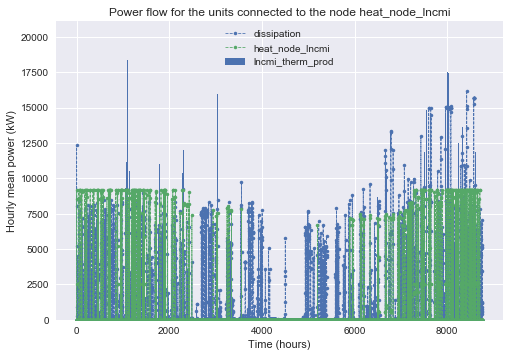

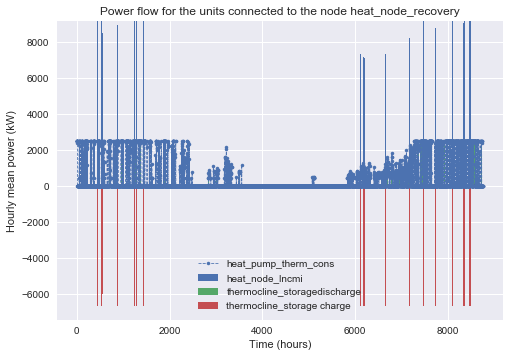

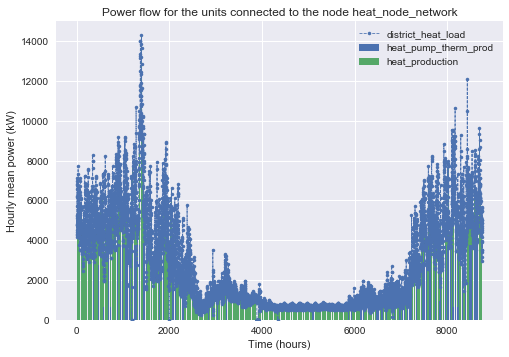

In [27]:
# Plot results for a given storage capacity
plot_results(heat_node_lncmi[20], heat_node_recovery[20], heat_node_network[20])

In [28]:
# Save results
for sto_capa in storage_capa:
    file_name =  'results\lncmi_flows_{0}_storage_capa_{1}'.format(strategy_name, sto_capa)
    save_energy_flows(heat_node_lncmi[sto_capa], heat_node_recovery[sto_capa], heat_node_network[sto_capa],file_name=file_name, sep=';')

### Model instanciation fixed

In [29]:
strategy_name = 'fixed' 
lncmi_f={}
heat_pump_f={} 
heat_production_f={}
district_heat_load_f={} 
heat_node_lncmi_f={} 
heat_node_recovery_f={} 
heat_node_network_f={}

# Simply changing the lncmi_cons to the original one, lncmi_elec

for sto_capa in storage_capa:
    print("Study for a storage capacity of {} MWh".format(sto_capa))
    lncmi_f[sto_capa], heat_pump_f[sto_capa], heat_production_f[sto_capa], district_heat_load_f[sto_capa], heat_node_lncmi_f[sto_capa], heat_node_recovery_f[sto_capa], heat_node_network_f[sto_capa] = lncmi_model(dt, start_date, end_date, lncmi_cons_config, lncmi_cons=lncmi_elec, 
                heat_cons=heat_cons, water_logic_values=heating_network_temp, 
                elec_to_heat_ratio=elec_to_heat_ratio, storage_capa=sto_capa, cciag_pmax=cciag_pmax,
                e_lncmi=e_set_lncmi, p_thresh_reco=p_min_export, lncmi_power=lncmi_power, 
                winter_only=winter_only, water_logic=water_logic)


Study for a storage capacity of 0 MWh
You are studying the period from 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Creating the lncmi_therm_prod.
Creating the lncmi_elec_cons.
Creating the lncmi.
Creating the dissipation.
Creating the district_heat_load.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the elec_prod.
Creating the heat_production.
Creating the heat_node_lncmi.
Creating the heat_node_recovery.
Creating the heat_node_network.
Creating the elec_node.


C:\Users\hodencqs\Anaconda3\envs\worklab\lib\site-packages\omegalpes\general\optimisation\model.py:573: UserWarning: The unit heat_node_lncmi seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  warnings.warn('The unit {} seems to have as parent {} '
C:\Users\hodencqs\Anaconda3\envs\worklab\lib\site-packages\omegalpes\general\optimisation\model.py:573: UserWarning: The unit heat_node_lncmi seems to have as parent p_thresh_recovery which was not declared as parent.
  warnings.warn('The unit {} seems to have as parent {} '



--- Adding all variables to the model ---
Adding variable : heat_node_lncmi_energy_export_to_heat_node_recovery
Adding variable : heat_node_lncmi_is_exporting_to_heat_node_recovery
Adding variable : lncmi_therm_prod_p
Adding variable : lncmi_therm_prod_e_tot
Adding variable : lncmi_therm_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : lncmi_elec_cons_p
Adding variable : lncmi_elec_cons_e_tot
Adding variable : heat_pump_therm_cons_p
Adding variable : heat_pump_therm_cons_e_tot
Adding variable : heat_pump_therm_cons_u
Adding variable : heat_pump_COP
Adding variable : heat_pump_therm_prod_p
Adding variable : heat_pump_therm_prod_e_tot
Adding variable : heat_pump_therm_prod_u
Adding variable : heat_pump_elec_cons_p
Adding variable : heat_pump_elec_cons_e_tot
Adding variable : heat_pump_elec_cons_u
Adding variable : heat_production_p
Adding variable : heat_production_e_tot
Adding variable : heat_production_u
Addin

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_discharging , exp = thermocline_storage_pd[t] - (1 - thermocline_storage_uc[t]) * thermocline_storage_pd_max <= 0 for t in time.I
Adding constraint : thermocline_storage_def_min_charging , exp = thermocline

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_set_soc_min , exp = thermocline_storage_e[t] >= 0 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_set_soc_max , exp = thermocline_storage_e[t] <= 1 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_set_soc_min , exp = thermocline_storage_e[t] >= 0 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_set_soc_max , exp = thermocline_storage_e[t] <= 1 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

Adding constraint : thermocline_storage_set_soc_min , exp = thermocline_storage_e[t] >= 0 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_set_soc_max , exp = thermocline_storage_e[t] <= 1 * thermocline_storage_capacity for t in time.I
Adding constraint : thermocline_storage_calc_e , exp = thermocline_storage_e[t+1] - thermocline_storage_e[t]*(1-0*time.DT) - time.DT * (thermocline_storage_pc[t]*1- thermocline_storage_pd[t]*1/1- 0*thermocline_storage_capacity) == 0 for t in time.I[:-1]
Adding constraint : thermocline_storage_calc_p , exp = thermocline_storage_p[t] == thermocline_storage_pc[t] - thermocline_storage_pd[t] for t in time.I
Adding constraint : thermocline_storage_on_off_stor , exp = thermocline_storage_pc[t] + thermocline_storage_pd[t] - thermocline_storage_u[t] * 0.001 >= 0 for t in time.I
Adding constraint : thermocline_storage_def_max_charging , exp = thermocline_storage_pc[t] - thermocline_storage_uc[t] * thermocline_storage_pc_max <

Adding constraint : heat_pump_therm_prod_on_off_min , exp = heat_pump_therm_prod_p[t] >= heat_pump_therm_prod_u[t] * 1e-05 for t in time.I
Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_pump_elec_cons_on_off_max , exp = heat_pump_elec_cons_p[t] <= heat_pump_elec_cons_u[t] * 1260 for t in time.I
Adding constraint : heat_pump_elec_cons_on_off_min , exp = heat_pump_elec_cons_p[t] >= heat_pump_elec_cons_u[t] * 214.20000000000002 for t in time.I
Adding constraint : heat_node_network_power_balance , exp = heat_pump_therm_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 20000.0 for t in time.I
Adding constraint :

In [30]:
# Save results
for sto_capa in storage_capa:
    file_name =  'results\lncmi_flows_{0}_storage_capa_{1}'.format(strategy_name, sto_capa)
    save_energy_flows(heat_node_lncmi_f[sto_capa], heat_node_recovery_f[sto_capa], heat_node_network_f[sto_capa],file_name=file_name, sep=';')

#### Exergy analysis

In [31]:
# -------------------------------------------------------------------------------------------------------------------
# THE SIMULATION STARTS HERE -- Please enter values for the waste heat management strategy and the storage capacity
# -------------------------------------------------------------------------------------------------------------------

# Provide always a list, even if just one strategy or storage capacity is to be simulated
strategy = ["RECOVERY", "FLEXENER", "FLEXTEMP", "DOUBLEFLEX"]  # "RECOVERY", "FLEXENER", "FLEXTEMP", and/or "DOUBLEFLEX"
storage_capacity = ["0", "10", "20", "30", "40"]  # To choose from "0", "10", "20", "30" and "40"

# GENERATING EMPTY LISTS AND DICTIONARIES FOR LATER MANAGEMENT OF THE RESULTS
scenarios_list = []
q_rec_list = []
ex_dest_list = []
empty_results_list = [[] for _ in range(len(storage_capacity))]
empty_results_list2 = [[] for _ in range(len(storage_capacity))]
storage_capacities_list = [v + " MWh" for v in storage_capacity]
dict_energy_results_by_storages = dict(zip(storage_capacities_list, empty_results_list))  # Empty dictionary of results
dict_exergy_results_by_storages = dict(zip(storage_capacities_list, empty_results_list2))  # Empty dictionary of results

q_ref, ex_dest_ref = exergy_assessment_heat_recovery("REFERENCE", "0")  # exergy_assessment_heat_recovery: function in utils
scenarios_list.append("REFERENCE")
q_rec_list.append(q_ref)
ex_dest_list.append(ex_dest_ref)

for st in strategy:
    for ca in storage_capacity:
        scenario_name = st + "-" + ca
        q_rec, ex_dest = exergy_assessment_heat_recovery(st, ca)
        scenarios_list.append(scenario_name)
        q_rec_list.append(q_rec)
        ex_dest_list.append(ex_dest)
        dict_energy_results_by_storages[ca + " MWh"].append(q_rec)
        dict_exergy_results_by_storages[ca + " MWh"].append(ex_dest)

------
Scenario: REFERENCE-0
Total heat recovered = 0 kWh
Total exergy destruction by dissipation = 1148083.5482027058 kWh
------
------
Scenario: RECOVERY-0
Total heat recovered = 553647.6 kWh
Total exergy destruction by dissipation = 1665058.2904429655 kWh
------
------
Scenario: RECOVERY-10
Total heat recovered = 1690245.4716666786 kWh
Total exergy destruction by dissipation = 1496882.070755585 kWh
------
------
Scenario: RECOVERY-20
Total heat recovered = 2514650.7300000074 kWh
Total exergy destruction by dissipation = 1375309.3240954063 kWh
------
------
Scenario: RECOVERY-30
Total heat recovered = 3014964.399966664 kWh
Total exergy destruction by dissipation = 1302116.305051221 kWh
------
------
Scenario: RECOVERY-40
Total heat recovered = 3285369.246950028 kWh
Total exergy destruction by dissipation = 1263243.6035706627 kWh
------
------
Scenario: FLEXENER-0
Total heat recovered = 1012434.4666666671 kWh
Total exergy destruction by dissipation = 1596571.5279355275 kWh
------
----

Exergy results dictionary: {'REFERENCE': [1148083.5482027058, 0, 0, 0, 0], '0 MWh': [0, 1665058.2904429655, 1596571.5279355275, 1296001.4994424875, 1171908.5978832762], '10 MWh': [0, 1496882.070755585, 1409534.3818291433, 1152380.9099885966, 974913.0551203821], '20 MWh': [0, 1375309.3240954063, 1238705.5148455019, 1018276.266637543, 819696.9735952953], '30 MWh': [0, 1302116.305051221, 1124391.2808063175, 939062.0354933292, 683156.053560473], '40 MWh': [0, 1263243.6035706627, 1062544.1287493105, 885266.3663896362, 618537.3362283098]}


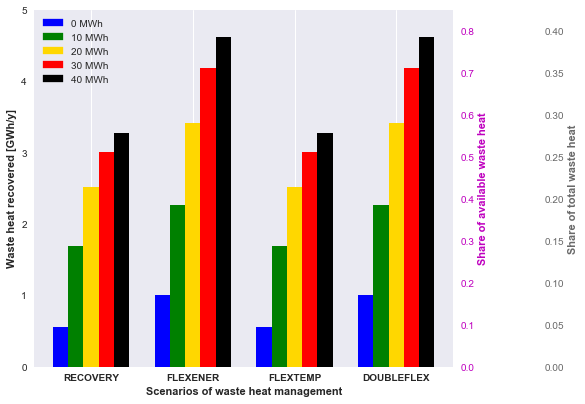

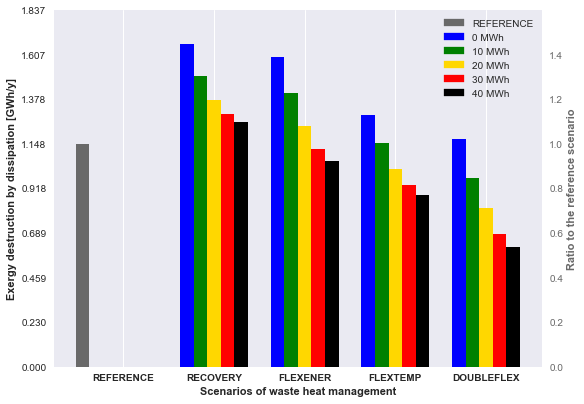

In [32]:
# -------------------------------------------------------------------------------------------------------------------
# CREATING FIGURE 1: BAR CHARTS OF WASTE HEAT RECOVERY UNDER DIFFERENT SCENARIOS ------------------------------------
# -------------------------------------------------------------------------------------------------------------------

# Color palette for the bar charts
colors = {'REFERENCE': 'dimgray', '0 MWh': 'b', '10 MWh': 'g', '20 MWh': 'gold', '30 MWh': 'r', '40 MWh': 'k'}

fig1, ax = plt.subplots(constrained_layout=True)

n = len(strategy)
ind = np.arange(n)  # the x locations for the groups of bars in the plot
width = 0.15  # width of each bar
f = 0  # counter for gliding the position of each bar series
for key in dict_energy_results_by_storages:
    values = dict_energy_results_by_storages[key]  # values to be plotted as bars
    ax.bar(ind + width * f, [v/1e6 for v in values], width, color=colors[key])  # gliding plot in GWh/y with its color
    f += 1

# ADJUSTING AXES, LABELS...
ax.set_xticks(ind+width*(len(dict_energy_results_by_storages.keys())-1)/2)
x_ticks_labels = tuple(strategy)
ax.set_xticklabels(x_ticks_labels, weight='bold')
plt.xlabel('Scenarios of waste heat management', weight='bold')
plt.ylabel('Waste heat recovered [GWh/y]', weight='bold')
y_max = math.ceil(max(i for v in dict_energy_results_by_storages.values() for i in v)/1e6) + 1
plt.yticks(np.arange(0, y_max, 1))
plt.grid(axis="y")
labels = list(dict_energy_results_by_storages.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[key]) for key in dict_energy_results_by_storages]
plt.legend(handles, labels)

# ADDING SECONDARY AND TERTIARY AXES TO THE FIGURE -- The functions below are for rescaling the axes


def yax2_direct_function(y):  # This function and the 3 other below are just for setting the y-axes ticks.
    return y * 0.17  # 1 GWh/y of waste heat recovered represents 17% of the available waste heat.


def yax2_inverse_function(y):
    return y / 0.17  # 17% of the available waste heat is equal to 1 GWh/y of waste heat recovered.


def yax3_direct_function(y):
    return y * 0.085  # 1 GWh/y of waste heat recovered represents 8.5% of total waste heat.


def yax3_inverse_function(y):
    return y / 0.085  # 8.5% of total waste heat is equal to 1 GWh/y of waste heat recovered.


# ADDING AND FORMATTING RIGHT Y-AXIS
yax2 = ax.secondary_yaxis("right", functions=(yax2_direct_function, yax2_inverse_function))
yax2.set_yticks(np.arange(0, 1.02, 0.17))
vals2 = yax2.get_yticks()
yax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals2])
yax2.set_ylabel('Share of available waste heat', weight='bold')
yax2.set_color('m')

# ADDING AND FORMATTING SECONDARY RIGHT Y-AXIS
yax3 = ax.secondary_yaxis(1.2, functions=(yax3_direct_function, yax3_inverse_function))
yax3.set_yticks(np.arange(0, 0.510, 0.085))
vals3 = yax3.get_yticks()
yax3.set_yticklabels(['{:,.0%}'.format(x) for x in vals3])
yax3.set_ylabel('Share of total waste heat', weight='bold')
yax3.set_color('dimgray')

# -------------------------------------------------------------------------------------------------------------------
# CREATING FIGURE 2: BAR CHARTS OF EXERGY DESTRUCTION DUE TO WASTE HEAT DISSIPATION UNDER DIFFERENT SCENARIOS -------
# -------------------------------------------------------------------------------------------------------------------

fig2, ax = plt.subplots(constrained_layout=True)
n = len(strategy) + 1
ind = np.arange(n)  # the x locations for the groups of bars in the plot
width = 0.15  # width of each bar

for v in dict_exergy_results_by_storages.values():
    v.insert(0, 0)

dict_exergy_ref = {'REFERENCE': [ex_dest_ref] + [0] * (len(strategy))}
dict_exergy_results_by_storages = {**dict_exergy_ref, **dict_exergy_results_by_storages}
print("Exergy results dictionary: {}".format(dict_exergy_results_by_storages))

f = 0
for key in dict_exergy_results_by_storages:
    values = dict_exergy_results_by_storages[key]
    ax.bar(ind + width * f, [v/1e6 for v in values], width, color=colors[key])
    f += 1

# ADJUSTING AXES, LABELS...
ax.set_xticks(ind+width*(len(dict_exergy_results_by_storages.keys())-0)/2)  # For centering scenarios' labels to bars
x_ticks_labels = tuple(["REFERENCE"] + strategy)
ax.set_xticklabels(x_ticks_labels, weight='bold')
plt.xlabel('Scenarios of waste heat management', weight='bold')
plt.ylabel('Exergy destruction by dissipation [GWh/y]', weight='bold')
y_max = math.ceil(max(i for v in dict_exergy_results_by_storages.values() for i in v)/1e6) + 0
plt.yticks(np.arange(0, y_max, 0.2296166))
plt.grid(axis="y")
labels = list(dict_exergy_results_by_storages.keys())
# print("Legend labels: {}".format(labels))  # For debug
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[key]) for key in dict_exergy_results_by_storages]
plt.legend(handles, labels)

# GENERATING RIGHT Y-AXIS -- The two functions here below are for re-scaling of the right axis


def fig2yax2_direct_function(y):  # This function and the other below are just for setting the y-axes ticks.
    return y * 0.871017  # 0.871017 = inverse of overall exergy destruction in the reference scenario (1.148 GWh/y)


def fig2yax2_inverse_function(y):
    return y / 0.871017  # 0.871017 = inverse of overall exergy destruction in the reference scenario (1.148 GWh/y)


# ADDING AND FORMATTING RIGHT Y-AXIS
yax2 = ax.secondary_yaxis("right", functions=(fig2yax2_direct_function, fig2yax2_inverse_function))
yax2.set_yticks(np.arange(0.00, 1.80, 0.20))
vals2 = yax2.get_yticks()
yax2.set_yticklabels(['{:,.2}'.format(x) for x in vals2])
yax2.set_ylabel('Ratio to the reference scenario', weight='bold')
yax2.set_color('dimgray')

plt.show()

#### Environemental assesment:

In [34]:
em_dhn_gre = 105  # tons of CO2e / GWh
em_elec = 60  # tons of CO2e / GWh
COP = 3

In [46]:
empty_results_list3 = [[] for _ in range(len(storage_capacity))]
dict_emissions_results_by_storages = dict(zip(storage_capacities_list, empty_results_list3))  # Empty dictionary of results

em_LNCMI = em_elec*lncmi[0].elec_consumption_unit.e_tot.value / 1e6
print("The emissions from the LNCMI electrical consumption are {} tons of CO2 eq.".format(round(em_LNCMI,2)))
# Fixed
for sto_capa in storage_capa:
    delta_em = heat_pump_f[sto_capa].thermal_production_unit.e_tot.value / 1e6*(em_dhn_gre-em_elec/COP)
    dict_emissions_results_by_storages[str(sto_capa) + " MWh"].append(delta_em)
    print("The avoided emissions are {0} tons of CO2 eq. per year, for a storage capacity of {1} with the recovery strategy".format(round(delta_em,2), sto_capa))
# Rearranged
for sto_capa in storage_capa:
    delta_em = heat_pump[sto_capa].thermal_production_unit.e_tot.value / 1e6*(em_dhn_gre-em_elec/COP)
    dict_emissions_results_by_storages[str(sto_capa) + " MWh"].append(delta_em)
    print("The avoided emissions are {0} tons of CO2 eq. per year, for a storage capacity of {1} with the flexener strategy".format(round(delta_em,2), sto_capa))

The emissions from the LNCMI electrical consumption are 826.43 tons of CO2 eq.
The avoided emissions are 70.59 tons of CO2 eq. per year, for a storage capacity of 0 with the recovery strategy
The avoided emissions are 215.51 tons of CO2 eq. per year, for a storage capacity of 10 with the recovery strategy
The avoided emissions are 320.62 tons of CO2 eq. per year, for a storage capacity of 20 with the recovery strategy
The avoided emissions are 384.41 tons of CO2 eq. per year, for a storage capacity of 30 with the recovery strategy
The avoided emissions are 418.88 tons of CO2 eq. per year, for a storage capacity of 40 with the recovery strategy
The avoided emissions are 129.09 tons of CO2 eq. per year, for a storage capacity of 0 with the flexener strategy
The avoided emissions are 289.9 tons of CO2 eq. per year, for a storage capacity of 10 with the flexener strategy
The avoided emissions are 436.32 tons of CO2 eq. per year, for a storage capacity of 20 with the flexener strategy
The a

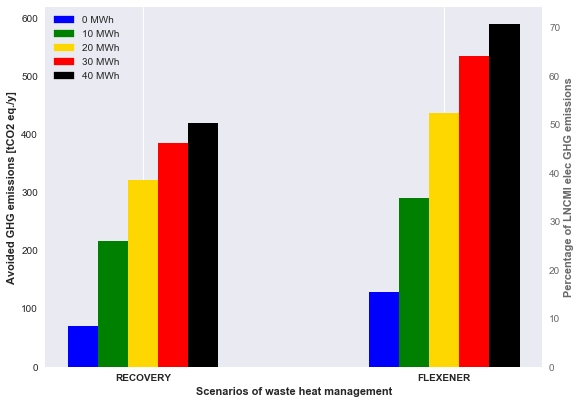

In [49]:
# Plotting
fig3, ax = plt.subplots(constrained_layout=True)
strategy = ["RECOVERY", "FLEXENER"]  # only two strategies consiedered here
n = len(strategy)
ind = np.arange(n)  # the x locations for the groups of bars in the plot
width = 0.1  # width of each bar
f = 0  # counter for gliding the position of each bar series
for key in dict_emissions_results_by_storages:
    values = dict_emissions_results_by_storages[key]  # values to be plotted as bars
    ax.bar(ind + width * f, [v for v in values], width, color=colors[key])  # gliding plot in GWh/y with its color
    f += 1

# ADJUSTING AXES, LABELS...
ax.set_xticks(ind+width*(len(dict_emissions_results_by_storages.keys())-1)/2)
x_ticks_labels = tuple(strategy)
ax.set_xticklabels(x_ticks_labels, weight='bold')
plt.xlabel('Scenarios of waste heat management', weight='bold')
plt.ylabel('Avoided GHG emissions [tCO2 eq./y]', weight='bold')
# y_max = math.ceil(max(i for v in dict_emissions_results_by_storages.values() for i in v)) + 1
# plt.yticks(np.arange(0, y_max, 1))
plt.grid(axis="y")
labels = list(dict_emissions_results_by_storages.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[key]) for key in dict_emissions_results_by_storages]
plt.legend(handles, labels)

# GENERATING RIGHT Y-AXIS -- The two functions here below are for re-scaling of the right axis
def fig3yax3_direct_function(y):  # This function and the other below are just for setting the y-axes ticks.
    return y * 0.12  # 100 tCO2eq/y represents 12% of the emissions from LNCMI electrical consumption.

def fig3yax3_inverse_function(y):
    return y / 0.12


# ADDING AND FORMATTING RIGHT Y-AXIS
yax2 = ax.secondary_yaxis("right", functions=(fig3yax3_direct_function, fig3yax3_inverse_function))
yax2.set_yticks(np.arange(0.00, 1.80, 0.20))
vals2 = yax2.get_yticks()
yax2.set_yticklabels(['{:,.2}'.format(x) for x in vals2])
yax2.set_ylabel('Percentage of LNCMI elec GHG emissions', weight='bold')
yax2.set_color('dimgray')

plt.show()

For a comprehensive environmental assessment, the life cycle analysis of the waste heat recovery system, and in particular the heat pump and thermal storage, should be carried out to consider their embedded GHG emissions. Moreover, it is very likely that the dynamics of the GHG emissions in both networks have a great influence on the results. In particular for the district heating network, whose main emissions are happing during the winter heating period, but these dynamic district heating network GHG emissions are not available. Still, this preliminary analysis provides a first order of magnitude for the saved GHG emissions. More refined work taking into account the dynamics of GHG emissions will be introduced in the perspectives.  

## Conclusion
This study analysed the effects of process flexibility in a case study of waste heat recovery. An electro-intensive facility in the city of Grenoble (France) rejects large amounts of waste heat that could be used to cover the heat needs of the district. The annual profiles of waste heat rejection and district needs are under strong mismatch, in terms of power, time and temperature. A heat recovery system consisting of a heat pump and a thermal storage unit can mitigate these mismatches.

Two innovative strategies were considered in order to support deployment of the heat recovery system through process flexibility. The first one consisted in exploiting the flexibility in the experiment planning of the facility. The second one consisted in adjusting the heat rejection temperature to more suitable values during periods of recovery, and as low as possible the rest of the time. The combination of both approaches was also investigated in the search for synergies. Performance of the heat recovery system was analysed, with each strategy, from the viewpoint of energy, exergy and environmental criteria. The indicators were, respectively: waste heat recovery index, exergy destruction and avoided CO2 emissions. The following conclusions were obtained from the study:

- Much of the waste heat is lost because rejection powers are sometimes insufficient to ensure constant temperature. This issue can only be solved through changes in the technology used for cooling down the magnets. Such approach falls out of the scope of this study.
- The prospective system can recover up to 78.6% of the waste heat that is eligible for recovery. However, that represents only 40% of the total waste heat, due to the abovementioned limitation. Thus, the system is relatively effective.
- Schedule rearrangement appears as complementary flexibility strategy compared to storage. The first can cover inter-seasonal time differences between the heat source and consumption with an organisational cost, while the second can cover power mismatches in addition to intraweek time differences with investment, maintenance and space costs.
- Both storage and schedule flexibility are necessary for high indexes of heat recovery. Only when combined, they allow up to 78.6% recovery. This index is greater than the simple addition of their separate contributions (= 72.6%), meaning that there exists a positive synergy between thermal storage and schedule flexibility.
- Temperature flexibility proved more effective than schedule flexibility in reducing exergy destruction: up to -21% versus -8%, respectively. The combination of both approaches reduced exergy destruction by as much as -44%, which was partly possible thanks to a positive synergy between them.
- Waste heat recovery is always recommendable from the energy viewpoint, but may be counterproductive from the exergy viewpoint if insufficient heat is recovered.
- This waste heat recovery project can lead to a net emissions reduction of about 600 tCO2e/year. This represents more than two thirds of the GHG emissions due to electricity consumption by the LNCMI.

### Perspectives
Several encouraging perspectives were identified. First, the environmental analysis could be refined using dynamic GHG emissions from electricity and heating networks, leading to new control strategies based on the minimisation of GHG emissions. Then, other indicators could be explored, for instance economic ones considering capital expenditures and operational expenses (including energy costs), and social indicators such as the security and diversity of supply (Santoyo-Castelazo and Azapagic, 2014). In addition, the calendar flexibility strategy could be improved through a sequential intra-week optimisation, where the weekly planning of experiments by researchers would be optimised too .

## Use case specifications

A summary sheet is proposed to describe the essential elements of the use casey to be used as metadata. 

| Name | LNCMI planning
| ---------------------------- | ------------------------------------------------------------------------------------------------------------ |
| Description | Waste heat recovery project at the French National Laboratory for High Magnetic Fields (LNCMI), involving its reasearchers as well as the district heating network operator, the CCIAG. 
| Objective | Rescheduling of the LNCMI planning of experiments in order to imporove the technical waste heat recovery potential of the facility, on the local district heating network | 
| Laboratory | G2Elab, LOCIE, LNCMI
|Contact | Sacha Hodencq, sacha.hodencq@g2elab.grenoble-inp.fr
|Link | [Link to the LNCMI planning notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/PhD_2022_Sacha_Hodencq/LNCMI_planning.ipynb)
|Documents and data | Coming article in Journal of Cleaner Production, <br>[Input data from the LNCMI](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/PhD_2022_Sacha_Hodencq/data/cons_lncmi_v7.csv) available on gitlab. 
| Associated tools | OMEGAlpes v0.4.1, licence Apache 2.0
|Licence | Open licence [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html)

|Parameter |Short description| Description 
| -------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Actors | *Primary*: LNCMI, CCIAG, Grenoble Alpes Métropole. *Secondary*: G2Elab, LOCIE. | LNCMI: Laboratory & electro-intensive actor, CCIAG: energy network operator, GAM:metropolis, G2Elab & LOCIE: research laboratories |
| Field of study | French National Laboratory for High Magnetic Fields (LNCMI), in the Presqu'île district, Grenoble, France |
|Issues | Waste heat recovery, Energy flexibility, Exergy | 
| Sectors | Electricity, heating |
| Analysis | Energy, exergy | Industrial electricity consumption, district heating network consumption, heat pump & storage system |
|Assumptions | Temperature of the heat network constant at 85°C. Pseudo steady state considered at each time step. Heat and pressure losses are neglected. Consumption of the heating network known a priori
| Nature of the use case | Support and supplementary material for a research article |
| How is the case study established? | Inductive method (bottom-up) applied to an actual use case, MILP optimisation 
| Why is the use case established? | Help to formulate, Study of solutions | Assistance in formulating the operation of the LNCMI in the MILP formalism, Study of solutions of energy and exergy interest
|Model refinement | Macroscopic |
| Representativity, transposability | Generic: Reference case for the use of low temperature waste heat for electro-intensive actors. Flexible and potentially representative consumption profiles for certain players (data centres) BUT <br>
Specific: Specific consumption profiles because linked to the LNCMI's experiments carried out: will not be representative of industrial processes. |
|Use phase | Opportunity analysis, feasibility |  |
| Time scale | Horizon: year - Time step: week - hour  |                                                                    |
| Spatial scale   | neighbourhood   |    
| Results   |  The formulation and solution of the MILP optimisation problem proved that both strategies are energy and exergy efficient for the recovery of the LNCMI waste heat.  ||
| Uncertainty analysis | ||